# RTA workload

The RTA or RTApp workload represents a type of workload obtained using the rt-app test application.
More details on the test application can be found at https://github.com/scheduler-tools/rt-app.

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup(level=0)

2018-02-08 22:02:28,761 INFO    : root         : Using LISA logging configuration:
2018-02-08 22:02:28,762 INFO    : root         :   /home/leoy/Work/tools/lisa-ml-20171106/logging.conf


In [2]:
# Generate plots inline
%pylab inline

import json
import os

# Support to initialise and configure your test environment
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp, Step, Pulse

# Suport for FTrace events parsing and visualization
import trappy

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

%matplotlib inline

import devlib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import trappy

from collections import OrderedDict
from csv import DictWriter
from env import TestEnv
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from scipy.stats import linregress
from scipy import polyfit
from time import sleep
from trappy.plotter.ColorMap import ColorMap

# Support for trace events analysis
from trace import Trace
# Import support for Android devices
from android import Screen, Workload, System

Populating the interactive namespace from numpy and matplotlib


2018-02-08 22:02:29,651 DEBUG   : JsonConf     : loading JSON...
2018-02-08 22:02:29,683 DEBUG   : JsonConf     : Loaded JSON configuration:
2018-02-08 22:02:29,684 DEBUG   : JsonConf     :    {u'board': {u'big_core': u'A15', u'cores': [u'A7', u'A7', u'A7', u'A7', u'A15', u'A15', u'A15', u'A15'], u'modules': [u'bl', u'cpufreq']}}
2018-02-08 22:02:29,689 DEBUG   : JsonConf     : loading JSON...
2018-02-08 22:02:29,690 DEBUG   : JsonConf     : Loaded JSON configuration:
2018-02-08 22:02:29,691 DEBUG   : JsonConf     :    {u'nrg_model': {u'big': {u'cluster': {u'nrg_max': 78}, u'cpu': {u'cap_max': 1024, u'nrg_max': 1893}}, u'little': {u'cluster': {u'nrg_max': 56}, u'cpu': {u'cap_max': 472, u'nrg_max': 215}}}, u'board': {u'big_core': u'A72', u'cores': [u'A53', u'A53', u'A53', u'A53', u'A72', u'A72'], u'modules': [u'bl', u'cpufreq', u'cpuidle']}}
2018-02-08 22:02:29,692 DEBUG   : JsonConf     : loading JSON...
2018-02-08 22:02:29,695 DEBUG   : JsonConf     : Loaded JSON configuration:
2018-0

## Test environment setup

For more details on this please check out **examples/utils/testenv_example.ipynb**.

In [3]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'android',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    
    # Energy Meters Configuration for BayLibre's ACME Cape
    #"emeter" : {
    #    "instrument" : "aep",
    #    "conf" : {
    #        'resistor_values' : [0.033],
    #        'device_entry'    : '/dev/ttyACM0'
    #    },
    #    "channel_map" : {
    #        "Device0" : "BAT"
    #    }
    #},
    
    # Preload settings for a specific target
    "board"       : 'hikey960',  # juno - JUNO board with mainline hwmon
    
    "device"      : "2450309301A1C7FB",
    
    "modules" : ['cpufreq', 'cpuidle', 'hotplug', 'cgroups', 'thermal', 'cpufreq'],

    "results_dir" : "scheduling_duration_baseline",
    
    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
         '0': 302, '1': 301, '2': 304, '3': 301, '4': 136, '5': 136, '6': 137, '7': 136
    }

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_capacity",
            "cpu_frequency",
            "sched_sugov_util"
         ],
         "buffsize" : 100 * 1024,
    },
}

In [4]:
# Initialize a test environment using
# - the provided target configuration (my_target_conf)
# - the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2018-02-08 22:02:30,356 INFO    : TestEnv      : Using base path: /home/leoy/Work/tools/lisa-ml-20171106
2018-02-08 22:02:30,357 INFO    : TestEnv      : Loading custom (inline) target configuration
2018-02-08 22:02:30,361 INFO    : TestEnv      : Loading custom (inline) test configuration
2018-02-08 22:02:30,363 WARNING : TestEnv      : Wipe previous contents of the results folder:
2018-02-08 22:02:30,366 WARNING : TestEnv      :    /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_baseline
2018-02-08 22:02:30,371 INFO    : TestEnv      : External tools using:
2018-02-08 22:02:30,372 INFO    : TestEnv      :    ANDROID_HOME: /home/leoy/Android/Sdk/
2018-02-08 22:02:30,377 INFO    : TestEnv      :    CATAPULT_HOME: /home/leoy/Work/tools/lisa-ml-20171106/tools/catapult
2018-02-08 22:02:30,379 INFO    : TestEnv      : Devlib modules to load: ['cgroups', 'cpufreq', 'bl', 'hotplug', 'thermal', 'cpuidle']
2018-02-08 22:02:30,380 INFO    : TestEnv      : Connecting Android t

2018-02-08 22:02:34,018 DEBUG   : CGroup.debug : Initialized [debug, 6, ['blkio', 'devices', 'freezer', 'hugetlb', 'debug']]
2018-02-08 22:02:34,116 DEBUG   : CGroup.debug : Controller debug mounted under: /data/local/tmp/devlib-target/cgroups/devlib_cgh6 (noprefix=False)
2018-02-08 22:02:34,118 DEBUG   : cgroups.debug : Creating cgroup /data/local/tmp/devlib-target/cgroups/devlib_cgh6
2018-02-08 22:02:34,166 INFO    : CGroups      :   debug        : /data/local/tmp/devlib-target/cgroups/devlib_cgh6
2018-02-08 22:02:36,247 INFO    : TestEnv      : Attempting to read energy model from target
2018-02-08 22:02:37,020 INFO    : TestEnv      : Topology:
2018-02-08 22:02:37,024 INFO    : TestEnv      :    [[0, 1, 2, 3], [4, 5, 6, 7]]
2018-02-08 22:02:37,165 INFO    : TestEnv      : Loading default EM:
2018-02-08 22:02:37,167 INFO    : TestEnv      :    /home/leoy/Work/tools/lisa-ml-20171106/libs/utils/platforms/hikey960.json
2018-02-08 22:02:37,170 DEBUG   : JsonConf     : loading JSON...
20

## Workload configuration

To create an instance of an RTApp workload generator you need to provide the following:
- target: target device configuration
- name: name of workload. This is the name of the JSON configuration file reporting the generated RTApp configuration.
- calibration: CPU load calibration values, measured on each core.

An RTApp workload is defined by specifying a **kind**, provided below through **rtapp.conf**, which represents the way we want to define the behavior of each task.
The possible kinds of workloads are **profile** and **custom**. It's very important to notice that **periodic** is no longer considered a "kind" of workload but a "class" within the **profile** kind.
<br><br>
As you see below, when "kind" is "profile", the tasks generated by this workload have a profile which is defined by a sequence of phases. These phases are defined according to the following grammar:<br>
 - params := {task, ...} <br>
 - task   := NAME : {SCLASS, PRIO, [phase, ...]}<br>
 - phase  := (PTIME, PERIOD, DCYCLE)<br> <br>
 
There are some pre-defined task classes for the **profile** kind:
 - **Step**: the load of this task is a step with a configured initial and final load. 
 - **Pulse**: the load of this task is a pulse with a configured initial and final load.The main difference with the 'step' class is that a pulse workload is by definition a 'step down', i.e. the workload switches from an initial load to a final one which is always lower than the initial one. Moreover, a pulse load does not generate a sleep phase in case of 0[%] load, i.e. the task ends as soon as the non null initial load has completed.
 - **Ramp**: the load of this task is a ramp with a configured number of steps determined by the input parameters.
 - **Periodic**: the load of this task is periodic with a configured period and duty-cycle.<br><br>
The one below is a workload mix having all types of workloads described above, but each of them can also be specified serapately in the RTApp parameters. 

In [16]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per5': Periodic(
            period_ms=15,         # period
            duty_cycle_pct=5,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),
        
        'task_per50': Periodic(
            period_ms=20,         # period
            duty_cycle_pct=30,     # duty cycle
            duration_s=10,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "OTHER",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),        
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2018-02-08 22:06:33,580 INFO    : Workload     : Setup new workload simple
2018-02-08 22:06:33,667 INFO    : Workload     : Workload duration defined by longest task
2018-02-08 22:06:33,669 INFO    : Workload     : Default policy: SCHED_OTHER
2018-02-08 22:06:33,670 INFO    : Workload     : ------------------------
2018-02-08 22:06:33,671 INFO    : Workload     : task [task_per5], sched: {'policy': 'OTHER'}
2018-02-08 22:06:33,672 INFO    : Workload     :  | loops count: 1
2018-02-08 22:06:33,674 INFO    : Workload     : + phase_000001: duration 10.000000 [s] (666 loops)
2018-02-08 22:06:33,675 INFO    : Workload     : |  period    15000 [us], duty_cycle   5 %
2018-02-08 22:06:33,677 INFO    : Workload     : |  run_time    750 [us], sleep_time  14250 [us]
2018-02-08 22:06:33,678 INFO    : Workload     : ------------------------
2018-02-08 22:06:33,679 INFO    : Workload     : task [task_per50], sched: {'policy': 'OTHER'}
2018-02-08 22:06:33,681 INFO    : Workload     :  | loops count: 

The output of the previous cell reports the main properties of the generated
tasks. Thus for example we see that the first task is configure to be:
 - named **task_per20**
 - executed as a **SCHED_FIFO** task
 - generating a load which is **calibrated** with respect to the **CPU 1**
 - with one single "phase" which defines a peripodic load for the **duration** of **5[s]**
 - that periodic load consistes of **50 cycles**
 - each cycle has a **period** of **100[ms]** and a **duty-cycle** of **20%**,
   which means that the task, for every cycle, will **run** for **20[ms]** and then sleep for **80[ms]** 

All these properties are translated into a JSON configuration file for RTApp which you can see in **Collected results** below.<br>

## Workload execution

In [17]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
#te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
#nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2018-02-08 22:06:34,693 INFO    : root         : #### Setup FTrace
2018-02-08 22:06:37,822 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-02-08 22:06:37,905 DEBUG   : FtraceCollector : Trace CPUIdle states
2018-02-08 22:06:38,008 INFO    : root         : #### Start energy sampling
2018-02-08 22:06:38,010 INFO    : root         : #### Start RTApp execution
2018-02-08 22:06:38,012 INFO    : Workload     : Workload execution START:
2018-02-08 22:06:38,013 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2018-02-08 22:06:48,378 INFO    : root         : #### Read energy consumption: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_baseline/energy.json
2018-02-08 22:06:48,380 INFO    : root         : #### Stop FTrace
2018-02-08 22:06:48,382 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2018-02-08 22:06:48,655 INFO    : root         : #### Save FTrace: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_baseline/trace.dat
2018-02-08 22:06:50,709 INFO    : root         : #### Save platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_baseline/platform.json


## Collected results

In [18]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
print json.dumps(rtapp_json, indent=4, sort_keys=True)

2018-02-08 22:06:50,719 INFO    : root         : Generated RTApp JSON file:


{
    "global": {
        "calibration": 136, 
        "default_policy": "SCHED_OTHER", 
        "duration": -1, 
        "logdir": "/data/local/tmp/devlib-target"
    }, 
    "tasks": {
        "task_per5": {
            "loop": 1, 
            "phases": {
                "p000001": {
                    "loop": 666, 
                    "run": 750, 
                    "timer": {
                        "period": 15000, 
                        "ref": "task_per5"
                    }
                }
            }, 
            "policy": "SCHED_OTHER"
        }, 
        "task_per50": {
            "loop": 1, 
            "phases": {
                "p000001": {
                    "loop": 500, 
                    "run": 6000, 
                    "timer": {
                        "period": 20000, 
                        "ref": "task_per50"
                    }
                }
            }, 
            "policy": "SCHED_OTHER"
        }
    }
}


In [19]:
# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
!ls -la {te.res_dir}

2018-02-08 22:06:50,862 INFO    : root         : Content of the output folder /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_baseline


total 7664
drwxrwxr-x  3 leoy leoy    4096 Feb  8 22:06 .
drwxrwxr-x 17 leoy leoy    4096 Feb  8 22:02 ..
-rw-rw-r--  1 leoy leoy   24815 Feb  8 22:03 cluster_freqs.png
-rw-rw-r--  1 leoy leoy     307 Feb  8 22:06 output.log
-rw-rw-r--  1 leoy leoy    1526 Feb  8 22:06 platform.json
-rw-r--r--  1 leoy leoy   62160 Feb  8 22:06 rt-app-task_per50-1.log
-rw-r--r--  1 leoy leoy   82744 Feb  8 22:06 rt-app-task_per5-0.log
-rw-r--r--  1 leoy leoy     954 Feb  8 22:06 simple_00.json
-rw-r--r--  1 leoy leoy 7643136 Feb  8 22:06 trace.dat
drwxrwxr-x  2 leoy leoy    4096 Feb  8 22:03 .trace.dat.cache


In [20]:
# Dump the energy measured for the LITTLE and big clusters
#logging.info('Energy: %s', nrg_report.report_file)
#print json.dumps(nrg_report.channels, indent=4, sort_keys=True)

NameError: name 'nrg_report' is not defined

In [21]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
print json.dumps(plt, indent=4, sort_keys=True)

2018-02-08 22:07:02,926 INFO    : root         : Platform description: /home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_baseline/platform.json


{
    "abi": "arm64", 
    "clusters": {
        "big": [
            4, 
            5, 
            6, 
            7
        ], 
        "little": [
            0, 
            1, 
            2, 
            3
        ]
    }, 
    "cpus_count": 8, 
    "freqs": {
        "big": [
            903000, 
            1421000, 
            1805000, 
            2112000, 
            2362000
        ], 
        "little": [
            533000, 
            999000, 
            1402000, 
            1709000, 
            1844000
        ]
    }, 
    "kernel": {
        "major": 9, 
        "minor": 79, 
        "parts": [
            4, 
            9, 
            79
        ], 
        "rc": null, 
        "release": "4.9.79-04507-gb9f4b25", 
        "sha1": "b9f4b25", 
        "version": "131 SMP PREEMPT Tue Feb 6 15:01:57 CST 2018", 
        "version_number": 4
    }, 
    "nrg_model": {
        "big": {
            "cluster": {
                "nrg_max": 433
            }, 
         

## Trace inspection

More information on visualization and trace inspection can be found in **examples/trappy**.

In [22]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:200: UserWarning: Cached data is from another trace, invalidating cache.
  warnings.warn(warnstr)


In [23]:
'''
Define platform parameters, these parameter is coming from
file platform.json; but we platform.json file is generated
after one running with LISA on the board. So for analysis
if we have no platform.json file we can define the variable
for this.
'''

platform = {
    'kernel': {
        'major': 4,
        'sha1': '78e8b90',
        'version': '57 SMP PREEMPT Sat Jul 1 15:42:00 CST 2017',
        'version_number': 4,
        'parts': [4, 4, 74],
        'rc': None,
        'release': '4.4.74-g78e8b90',
        'minor': 74
    },
    
    'freqs': {
        'big': [
            903000,
            1421000,
            1805000,
            2112000,
            2362000
        ],
        'little': [
            533000,
            999000,
            1402000,
            1709000,
            1844000]
    },
    
    'nrg_model': {
        'big': {
            'cluster': {
                'nrg_max': 559
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 4269
            }
        },
        'little': {
            'cluster': {
                'nrg_max': 181
            },
            'cpu': {
                'cap_max': 466,
                'nrg_max': 731
            }
        }
    },
    
    'clusters': {
        'big': [4, 5, 6, 7],
        'little': [0, 1, 2, 3]
    },
    'cpus_count': 8,
    'topology': [[0, 1, 2, 3], [4, 5, 6, 7]]
}


In [24]:
from trace import Trace
trace = Trace(platform, trace_file, events=my_target_conf['ftrace']['events'], normalize_time=True)

2018-02-08 22:07:06,343 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling_duration_baseline/trace.dat]...
2018-02-08 22:07:06,344 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_wakeup', 'sched_wakeup_new', 'sched_overutilized', 'sched_load_avg_cpu', 'sched_load_avg_task', 'cpu_capacity', 'cpu_frequency', 'sched_sugov_util', 'cpu_frequency_devlib', 'cpu_frequency_devlib']
2018-02-08 22:07:06,345 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_sugov_util object at 0x7f7eb4ff9150> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f7eb4ff9510> from cache, reading it from trace
  warnings.warn(warnstr)
/home/l

2018-02-08 22:07:07,856 DEBUG   : Analysis     :    cpus
2018-02-08 22:07:07,857 DEBUG   : Analysis     : Filename: idle_analysis
2018-02-08 22:07:07,865 DEBUG   : Trace        : Registering [<idle_analysis.IdleAnalysis object at 0x7f7eb5005e90>] local data frames
2018-02-08 22:07:07,867 DEBUG   : Trace        :    cluster_idle_state_residency
2018-02-08 22:07:07,868 DEBUG   : Trace        :    cpu_idle_state_residency
2018-02-08 22:07:07,870 DEBUG   : Trace        :    trace_event
2018-02-08 22:07:07,871 DEBUG   : Analysis     :    idle
2018-02-08 22:07:07,872 DEBUG   : Analysis     : Filename: frequency_analysis
2018-02-08 22:07:07,873 DEBUG   : Trace        : Registering [<frequency_analysis.FrequencyAnalysis object at 0x7f7eb5005910>] local data frames
2018-02-08 22:07:07,878 DEBUG   : Trace        :    cluster_frequency_residency
2018-02-08 22:07:07,879 DEBUG   : Trace        :    cpu_frequency_residency
2018-02-08 22:07:07,881 DEBUG   : Trace        :    trace_event
2018-02-08 22

2018-02-08 22:07:08,509 INFO    : Analysis     : LITTLE cluster average frequency: 1.676 GHz
2018-02-08 22:07:08,512 INFO    : Analysis     : big    cluster average frequency: 1.589 GHz
2018-02-08 22:07:08,514 INFO    : root         : Plotting cluster frequencies for [sched]...


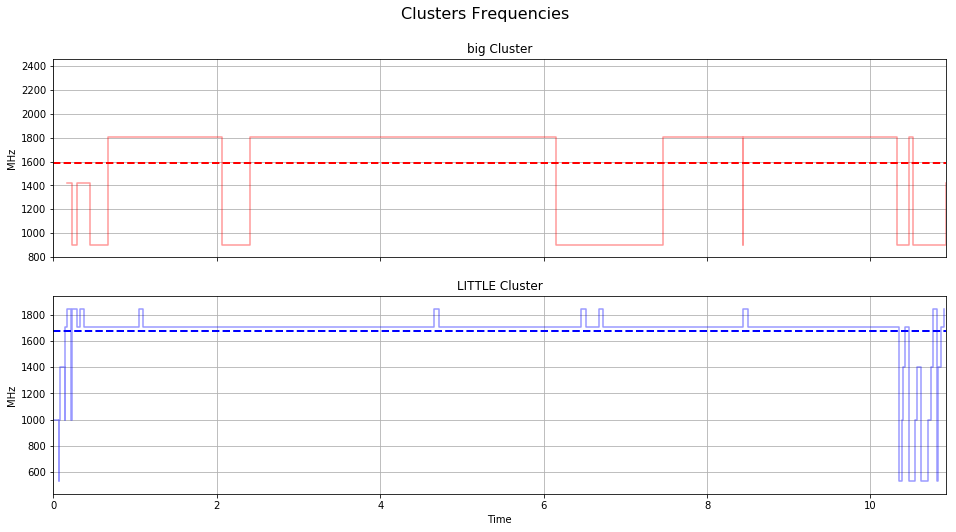

In [25]:
try:
    trace.analysis.frequency.plotClusterFrequencies();
    logging.info('Plotting cluster frequencies for [sched]...')
except: pass

## RTApp task performance plots

2018-02-08 21:55:25,838 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per50]
2018-02-08 21:55:25,840 DEBUG   : PerfAnalysis : Found rt-app logfile for task [task_per5]
2018-02-08 21:55:25,841 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per5]...
2018-02-08 21:55:25,852 DEBUG   : PerfAnalysis : Loading dataframe for task [task_per50]...
2018-02-08 21:55:26,381 INFO    : PerfAnalysis : PerfIndex, Task [task_per5] avg: 0.64, std: 0.11
2018-02-08 21:55:27,139 INFO    : PerfAnalysis : PerfIndex, Task [task_per50] avg: 0.61, std: 0.11


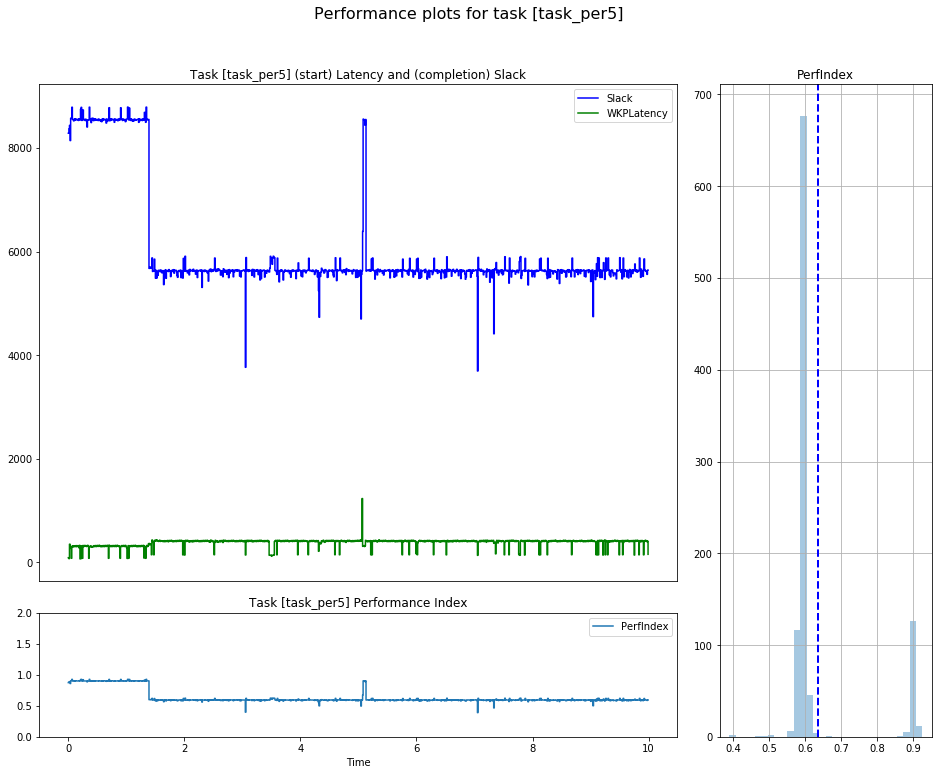

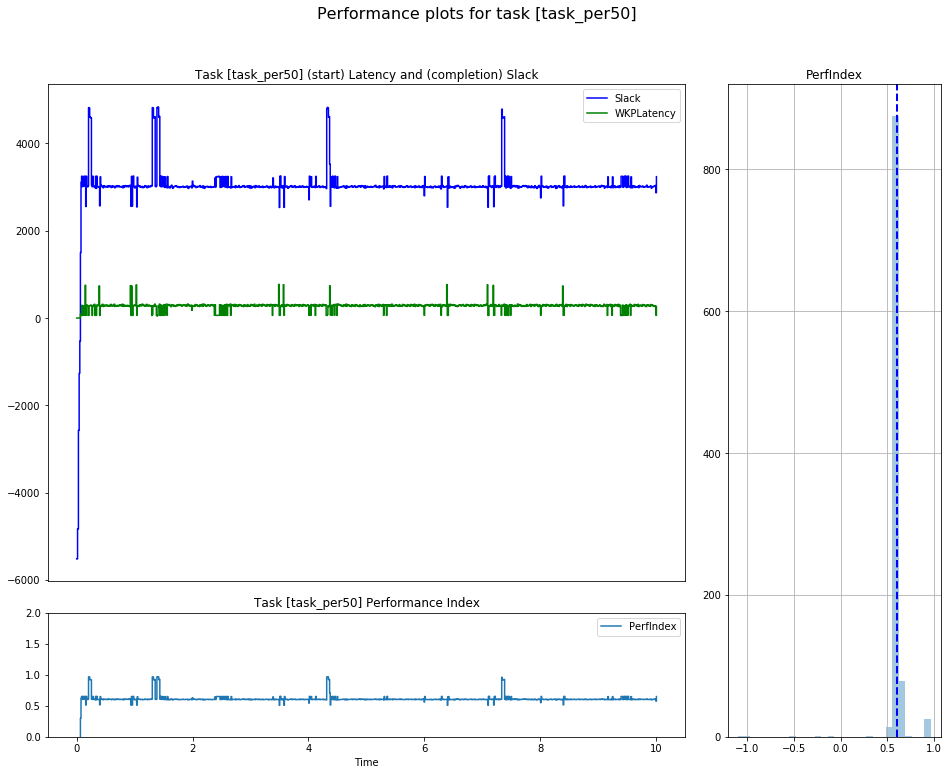

In [18]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

In [13]:
# Analyse CPU utilization standard devation
def analysis_energy_calculation_duration():

    df = trace.data_frame.trace_event('sched_energy_calc_duration')
    
    if df.empty:
        return
    
    calc_duration_df = pd.DataFrame(
        {
            'max': [int(df['duration'].max())],
            'min': [int(df['duration'].min())],
            'mean': [int(df['duration'].mean())],
        },
    )
    
    return calc_duration_df

In [16]:
'''
Define platform parameters, these parameter is coming from
file platform.json; but we platform.json file is generated
after one running with LISA on the board. So for analysis
if we have no platform.json file we can define the variable
for this.
'''

platform = {
    'kernel': {
        'major': 4,
        'sha1': '78e8b90',
        'version': '57 SMP PREEMPT Sat Jul 1 15:42:00 CST 2017',
        'version_number': 4,
        'parts': [4, 4, 74],
        'rc': None,
        'release': '4.4.74-g78e8b90',
        'minor': 74
    },
    
    'freqs': {
        'big': [
            903000,
            1421000,
            1805000,
            2112000,
            2362000
        ],
        'little': [
            533000,
            999000,
            1402000,
            1709000,
            1844000]
    },
    
    'nrg_model': {
        'big': {
            'cluster': {
                'nrg_max': 559
            },
            'cpu': {
                'cap_max': 1024,
                'nrg_max': 4269
            }
        },
        'little': {
            'cluster': {
                'nrg_max': 181
            },
            'cpu': {
                'cap_max': 466,
                'nrg_max': 731
            }
        }
    },
    
    'clusters': {
        'big': [4, 5, 6, 7],
        'little': [0, 1, 2, 3]
    },
    'cpus_count': 8,
    'topology': [[0, 1, 2, 3], [4, 5, 6, 7]]
}

In [18]:
trace = Trace(platform, trace_file, events=my_tests_conf['ftrace']['events'], normalize_time=True)

2018-01-19 10:48:35,233 DEBUG   : Trace        : Loading [sched] events from trace in [/home/leoy/Work/tools/lisa-ml-20171106/results/scheduling duration profiling/trace.dat]...
2018-01-19 10:48:35,235 DEBUG   : Trace        : Parsing events: ['sched_switch', 'cpu_frequency', 'sched_energy_calc_duration', 'cpu_frequency_devlib']
2018-01-19 10:48:35,237 DEBUG   : Trace        : Parsing FTrace format...
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_energy_calc_duration object at 0x7f56f05d28d0> from cache, reading it from trace
  warnings.warn(warnstr)
/home/leoy/Work/tools/lisa-ml-20171106/libs/trappy/trappy/ftrace.py:273: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7f56b845cdd0> from cache, reading it from trace
  warnings.warn(warnstr)
2018-01-19 10:48:35,813 DEBUG   : Trace        : Events found on trace:
2018-01-19 10:48:35,814 DEBUG   : Trace        :  - cpu_f

2018-01-19 10:48:36,106 DEBUG   : Trace        :    trace_event
2018-01-19 10:48:36,108 DEBUG   : Analysis     :    frequency
2018-01-19 10:48:36,109 DEBUG   : Analysis     : Filename: latency_analysis
2018-01-19 10:48:36,120 DEBUG   : Trace        : Registering [<latency_analysis.LatencyAnalysis object at 0x7f56b9ae6190>] local data frames
2018-01-19 10:48:36,121 DEBUG   : Trace        :    activations_df
2018-01-19 10:48:36,122 DEBUG   : Trace        :    latency_df
2018-01-19 10:48:36,123 DEBUG   : Trace        :    latency_preemption_df
2018-01-19 10:48:36,124 DEBUG   : Trace        :    latency_wakeup_df
2018-01-19 10:48:36,125 DEBUG   : Trace        :    runtimes_df
2018-01-19 10:48:36,126 DEBUG   : Trace        :    trace_event
2018-01-19 10:48:36,127 DEBUG   : Analysis     :    latency


In [19]:
analysis_energy_calculation_duration()

,max,mean,min
0,41146,12387,3645
